# PCO. Modélisation IA (stratégies supplémentaires)
## Compétences C5. C6.

<img src='Ressources_NB/IllustrationModel2.png'>
    
Ce fichier contient les modélisation IA à partir des données traitées en amont durant l'analyse. A la différence de la première série de modélisation, ce notebook présente différentes stratégies de rééquilibrage des classes afin d'éventuellement améliorer le score *Recall* au détriment du *Log Loss*. Ces modèles ne seront pas retenus pour l'intrégation dans l'application. 

## Compétences
* **C5.** Concevoir le programme d’intelligence artificielle adapté aux données disponibles afin de répondre aux objectifs fonctionnels du projet, à l’aide des algorithmes, outils et méthodes standards, notamment de machine learning et de deep learning.
* **C6.** Développer le programme d’intelligence artificielle selon les données du projet et les éléments de conception définis, en exploitant les algorithmes et les outils standards couramment utilisés dans le domaine.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Importation des Fichiers

In [12]:
# Librairies standards de data-analyses:
    
import numpy as np
from numpy import set_printoptions
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import math


# sklearn modules Preprocessing:
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Samples processing:

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import TomekLinks


# sklearn modules Model Selection:

from sklearn import tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

import xgboost
from xgboost import XGBClassifier

#import lightgbm
#from lightgbm import LGBMClassifier


# sklearn modules Model Evaluation & Improvement:
    
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import learning_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import model_selection

from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from sklearn.metrics import make_scorer, recall_score, log_loss, matthews_corrcoef
from sklearn.metrics import average_precision_score
from sklearn.pipeline import make_pipeline


# Réseaux de neurones Tensorflow Keras:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
#from keras import backend as K


# Librairies standards de data-visualisation:

import seaborn as sn
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib 
%matplotlib inline
color = sn.color_palette()
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from IPython.display import display
pd.options.display.max_columns = None
from dateutil.relativedelta import relativedelta
import datetime
from datetime import date, datetime
import re
import joblib


# Filtre warnings:

import warnings 
warnings.filterwarnings("ignore")


# Coloration des graphes:

red = '#fd8181'
blue = '#8198fd'

## Fonctions
### Fonctions de Preprocessing

In [5]:
# Fonction détection des valeurs manquantes:
def find_NaN(dataset):
    NaN = dataset.isnull().sum().to_frame('Valeurs Manquantes')
    NaN = NaN.loc[NaN['Valeurs Manquantes']>0]
    NaN['Pourcentage'] = [str(round((i*100)/len(dataset),1)) for i in NaN['Valeurs Manquantes']]
    NaN['Pourcentage'] = [i+' %' for i in NaN['Pourcentage']]
    if NaN.empty:
        return print(f'Aucune valeur manquante n\'est détectée sur ce dataset')
    else:
        return NaN
    
# Fonction transformation date str(YYYY-MM-DD) en int(YYYYMMDD):    
def Format_intdate(serie):
    Liste = []
    for i in serie:
        y = i[:4]
        m = i[5:7]
        d = i[8:]
        i = f'{y}{m}{d}'
        i = int(i)
        Liste.append(i)

    return Liste

# Proportion Churn:
def ratio_churn(dataset, name):
    ratio = dataset['is_churn'].value_counts()[1]/len(dataset['is_churn'])
    print(f'Proportion désabonnés sur {name} :\t{round(ratio*100,2)} %')
    
def proportion_churn(dataset, target):
    labels = ['Abonnés', 'Désabonnés']
    colors = [blue, red]
    explode = (0, 0.2)
 
    fig, ax = plt.subplots()
    ax.pie(dataset[target].value_counts(), startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%', explode = explode, shadow=True)
    ax.set_title('Proportion d\'attrition', fontweight='bold')
   
    fig.set_figheight(5)
    fig.set_figwidth(5)
    fig.legend(loc='lower right', labels=labels, fontsize='medium')
    fig.tight_layout()

### Fonctions d'évaluation des modèles

In [6]:
# Comparaison Modèles:
def compare_model(results, score, names):
    Table = pd.DataFrame(columns=names)
    for i,j in zip(Table.columns, results):
        Table[i] = j
    
    plt.figure(figsize=(20,6))  
    sn.boxplot(data=Table.loc[:, names], palette="Set3", linewidth=2.5, orient="h")
    
    plt.ylabel(f'\n Modèles utilisés\n',horizontalalignment="center",fontstyle = "normal",fontsize = "large", fontfamily = "sans-serif")
    plt.xlabel(f'{score} Score\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
    plt.title(f'Comparaison {score} \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
    plt.xticks(rotation=0, horizontalalignment="center")
    plt.yticks(rotation=0, horizontalalignment="right")
    plt.grid(True)
    plt.show()
    
    
# Vérification saturation de données:
def learning_Model(model, name):    
    N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes = np.linspace(0.1, 1.0, 7), cv = StratifiedKFold(4), scoring = 'f1')
    
    plt.figure(figsize = (12, 7))
    plt.plot(N, train_score.mean(axis=1), '-o', label = 'train')
    plt.fill_between(N, train_score.max(axis=1), train_score.min(axis=1), alpha=0.3)
    plt.plot(N, val_score.mean(axis=1), '-o', label = 'validation')
    plt.fill_between(N, val_score.max(axis=1), val_score.min(axis=1), alpha=0.3)
    plt.title(f'Historique de l\'apprentissage {name}\n')
    plt.ylabel('Score (F1)')
    plt.xlabel('Samples')
    plt.legend()

    plt.show()
    
# Entrainement et Evaluation du modèle
def First_Evaluation(name):
    print(f'Evaluation sur {name}')

    plt.figure(figsize = (7, 5))
    df_cm = confusion_matrix(y_valid, y_pred) 
    group_names = ["True Neg\n", "False Pos\n", "False Neg\n", "True Pos\n"]
    group_counts = ["{0:0.0f}\n".format(value) for value in df_cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in df_cm.flatten()/np.sum(df_cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=labels, fmt="", cmap='mako').set_title('Confusion matrix Validation\n')
    class_names=[0,1]
    tick_marks = np.arange(len(class_names))
    plt.tight_layout()

    plt.ylabel('Actual label')
    plt.xlabel('Predicted label\n')
    plt.show()
    
    predictions_result = pd.DataFrame(columns = ['True', 'Probability', 'Prediction'])
    predictions_result['True'] = y_valid.tolist()
    predictions_result['Probability'] = probability.tolist()
    predictions_result['Prediction'] = y_pred.tolist()
    
    try :
        predictions_result_o = predictions_result.loc[predictions_result['Probability']>0.9]
        certitude_1 = round(predictions_result_o['True'].value_counts()[1]/len(predictions_result_o['True']),2)
        predictions_result_u = predictions_result.loc[predictions_result['Probability']<0.1]
        certitude_0 = round(predictions_result_u['True'].value_counts()[0]/len(predictions_result_u['True']),2)
        print(f'Confiance sur 1 pour probabilité de prédiction > 90 % : {certitude_1*100} %')
        print(f'Confiance sur 0 pour probabilité de prédiction < 10 % : {certitude_0*100} %')
        
    except :
        pass

    probability_md = [i for i in probability if 0.1<i<0.9]
    part = round(len(probability_md)*100/len(probability),2)
    
    print(f'Nombre Utilisateur avec probabilité entre 10 et 90% : {len(probability_md)} ({part} %)')

## Preprocessing

In [ ]:
Dataset = pd.read_csv('/content/gdrive/My Drive/microsoft_ia/Analyses Projet CO/CSV_checkpoint/Dataset_F.csv')

# Suppression des variables temporelles:
Dataset = Dataset.drop(['transaction_date'], 1)
Dataset['membership_expire_date'] = Format_intdate(Dataset['membership_expire_date'])
Dataset['registration_init_time'] = Format_intdate(Dataset['registration_init_time'])

# Afin d'effectuer un futur encodage:
Dataset['city'] = [str(i)+'C' for i in Dataset.city]
Dataset['payment_method_id'] = [str(i)+'P' for i in Dataset.payment_method_id]
Dataset['registered_via'] = [str(i)+'R' for i in Dataset.registered_via]

# Encodage:
Dataset = pd.concat([Dataset, pd.get_dummies(Dataset.gender)],1)
Dataset = pd.concat([Dataset, pd.get_dummies(Dataset.payment_method_id)],1)
Dataset = pd.concat([Dataset, pd.get_dummies(Dataset.registered_via)],1)
Dataset = pd.concat([Dataset, pd.get_dummies(Dataset.city)],1)
Dataset = Dataset.drop(['gender', 'payment_method_id','registered_via', 'city'], 1)

# Vérification:
find_NaN(Dataset)

Dataset.head()

Aucune valeur manquante n'est détectée sur ce dataset


,msno,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,membership_expire_date,is_cancel,transaction_count,bd,registration_init_time,num_25Sum,num_50Sum,num_75Sum,num_985Sum,num_100Sum,num_unqSum,total_secsSum,num_25Mean,num_50Mean,num_75Mean,num_985Mean,num_100Mean,num_unqMean,total_secsMean,count,is_churn,price_per_day,days_fidelity,female,inconnu,male,10P,11P,12P,13P,14P,15P,16P,17P,18P,19P,20P,21P,22P,23P,26P,27P,28P,29P,30P,31P,32P,33P,34P,35P,36P,37P,38P,39P,3P,40P,41P,6P,8P,13R,3R,4R,7R,9R,10C,11C,12C,13C,14C,15C,16C,17C,18C,19C,1C,20C,21C,22C,3C,4C,5C,6C,7C,8C,9C
0,+++IubgjAxvn,30,99,99,1,20170402,0,1,-1,20160503,200.0,47.0,42.0,39.0,747.0,684.0,220954.5830,6.896552,1.620690,1.448276,1.344828,25.758621,23.586207,7619.123552,29,0,3.300000,334,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,+++KGJ1Vi2lH,30,149,149,1,20170406,0,1,27,20111001,212.0,37.0,38.0,34.0,401.0,585.0,116986.9040,7.851852,1.370370,1.407407,1.259259,14.851852,21.666667,4332.848296,27,0,4.966667,2014,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,+++MqaETxAaV,30,99,99,1,20170427,0,1,-1,20151128,41.0,9.0,3.0,9.0,624.0,509.0,140733.2220,1.708333,0.375000,0.125000,0.375000,26.000000,21.208333,5863.884250,24,0,3.300000,516,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,+++l4M/sEnP0,30,149,149,1,20170503,0,2,25,20160928,219.0,39.0,32.0,34.0,2201.0,1792.0,542811.6555,7.300000,1.300000,1.066667,1.133333,73.366667,59.733333,18093.721850,30,0,4.966667,217,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,+++r/zNZrW5d,30,149,149,1,20170402,0,1,25,20070506,192.0,41.0,25.0,27.0,862.0,765.0,231866.1780,6.400000,1.366667,0.833333,0.900000,28.733333,25.500000,7728.872600,30,0,4.966667,3619,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


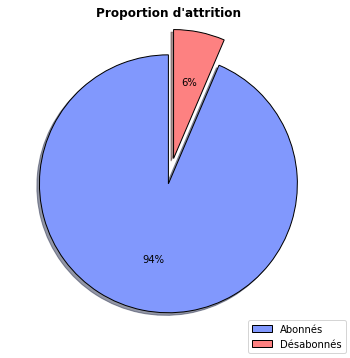

In [ ]:
proportion_churn(Dataset, 'is_churn')

In [ ]:
# Split
r =  40
Train, REM = train_test_split(Dataset, train_size=0.7, stratify = Dataset['is_churn'], random_state = r)
Valid, Test = train_test_split(REM, test_size=0.2, stratify = REM['is_churn'], random_state = r)
print(f'Dimensions Train : {Train.shape}')
print(f'Dimensions Valid : {Valid.shape}')
print(f'Dimensions Test  : {Test.shape}\n')

# Vérification de la proportion churn:
ratio_churn(Train,'Train')
ratio_churn(Valid,'Valid')
ratio_churn(Test,'Test')

# Définition de features X et Target Y
X_train = Train.drop(['msno','is_churn'], axis = 1)
y_train = Train['is_churn'].astype(int)

X_valid = Valid.drop(['msno','is_churn'], axis = 1)
y_valid = Valid['is_churn'].astype(int)

print("\nDimension X_train dataset: ", X_train.shape)
print("Dimension y_train dataset: ",   y_train.shape)
print("Dimension X_valid dataset: ",   X_valid.shape)
print("Dimension y_valid dataset: ",   y_valid.shape)

# Standardisation des données
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2

# scaler = joblib.dump(sc_X, '/content/gdrive/My Drive/microsoft_ia/Analyses Projet CO/ScalerXGBC_BF.joblib')

X_valid2 = pd.DataFrame(sc_X.transform(X_valid))
X_valid2.columns = X_valid.columns.values
X_valid2.index = X_valid.index.values
X_valid = X_valid2

Dimensions Train : (508005, 90)
Dimensions Valid : (174173, 90)
Dimensions Test  : (43544, 90)

Proportion désabonnés sur Train :	6.42 %
Proportion désabonnés sur Valid :	6.42 %
Proportion désabonnés sur Test :	6.42 %

Dimension X_train dataset:  (508005, 88)
Dimension y_train dataset:  (508005,)
Dimension X_valid dataset:  (174173, 88)
Dimension y_valid dataset:  (174173,)


## Stratégie de Sous-Echantillonnage
Dans cette partie, un sous-échantillonnage sera effectué sur la classe Majoritaire. *NearMiss-3* sera utilisé pour vérifier les performances des modèles après équilibrages des données d'apprentissage. D'autres techniques comme *Condensed Nearest Neighbor* ou *TomekLinks* présente une finalité similaire mais en sélectionnant différemment les données de la classe majoritaire. Ces deux dernières techniques ne seront pas utilisés car ce sont des algorithmes très coûteux en temps.

https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/

### NearMiss-3

NearMiss-3 est une méthode de sous-échantillonnage qui sélectionnent des exemples en fonction de la distance entre les exemples de classe majoritaire et les exemples de classe minoritaire (Jianping Zhang et Inderjeet Mani. *KNN Approach to Unbalanced Data Distributions: A Case Study Involving Information Extraction.* 2003).

In [ ]:
from imblearn.under_sampling import NearMiss

# Transformation:
NearMiss_sample = NearMiss(version=3, n_neighbors_ver3=3)
X_NM3, y_NM3 = NearMiss_sample.fit_resample(X_train, y_train)

Taille du Dataset Train = 65244


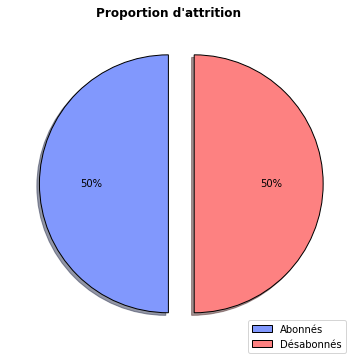

In [ ]:
print(f'Taille du Dataset Train = {y_NM3.shape[0]}')
proportion_churn(y_NM3.to_frame(), 'is_churn')

In [ ]:
%%time


models = []
models.append([LogisticRegression(), 'Logistic Regression'])
models.append([GaussianNB(), 'Naive Bayes Classifier'])
models.append([DecisionTreeClassifier(), 'Decision Tree Classifier'])
models.append([RandomForestClassifier(), 'Random Forest Classifier'])
models.append([BaggingClassifier(), 'Bagging Classifier'])
models.append([AdaBoostClassifier(), 'AdaBoost Classifier'])
models.append([LGBMClassifier(metrics = 'binary_logloss', objective='binary'), 'LightGBM Classifier'])
models.append([XGBClassifier(eval_metric = 'logloss', objective = 'binary:logistic', tree_method='hist'), 'XGBoost Classifier'])

# Evaluation des modèles:
names = []
auc_results_NM3 = []
loss_results_NM3 = []
f1_results_NM3 = []
precision_results_NM3 = []
recall_results_NM3 = []
MCC_results_NM3 = []

# Création d'un tableau reportant les performances de chaque modèle:
col = ['Model', 'ROC AUC Mean', 'ROC AUC STD', 'Log loss Mean', 'Log loss STD', 
       'F1 Mean', 'F1 STD', 'Precision Mean', 'Precision STD', 'Recall Mean', 
       'Recall STD', 'MCC Mean', 'MCC STD']

model_results_NM3 = pd.DataFrame(columns=col)

# Metrics :
scoring = {"AUC": "roc_auc", 
           "Loss": 'neg_log_loss',
           "F1" : 'f1',
           "Precision":'precision',
           "Recall":'recall',
           "MCC": metrics.make_scorer(matthews_corrcoef)}
i = 0

# Evaluation des modèles utilisant le k-fold cross-validation:
for model, name in models:
    print(f'Entrainement en cours sur : {name}')
    
    # Score:
    
    cv_results = model_selection.cross_validate(model, X_NM3, y_NM3, cv = StratifiedKFold(5), scoring = scoring)
    
    auc_results_NM3.append(cv_results['test_AUC'])
    loss_results_NM3.append(cv_results['test_Loss'])
    f1_results_NM3.append(cv_results['test_F1'])
    precision_results_NM3.append(cv_results['test_Precision'])
    recall_results_NM3.append(cv_results['test_Recall'])
    MCC_results_NM3.append(cv_results['test_MCC'])
    
    names.append(name)
    model_results_NM3.loc[i] = [name,
                            round(cv_results['test_AUC'].mean()*100, 2),
                            round(cv_results['test_AUC'].std()*100, 2),
                            round(cv_results['test_Loss'].mean()*-1, 2),
                            round(cv_results['test_Loss'].std(), 2),
                            round(cv_results['test_F1'].mean()*100, 2),
                            round(cv_results['test_F1'].std()*100, 2),
                            round(cv_results['test_Precision'].mean()*100, 2),
                            round(cv_results['test_Precision'].std()*100, 2),
                            round(cv_results['test_Recall'].mean()*100, 2),
                            round(cv_results['test_Recall'].std()*100, 2),
                            round(cv_results['test_MCC'].mean()*100, 2),
                            round(cv_results['test_MCC'].std()*100, 2)]
    i += 1

model_results_NM3.to_csv('/content/gdrive/My Drive/microsoft_ia/Analyses Projet CO/Resultats/model_results_NM3.csv', index = False)

Entrainement en cours sur : Logistic Regression
Entrainement en cours sur : Naive Bayes Classifier
Entrainement en cours sur : Decision Tree Classifier
Entrainement en cours sur : Random Forest Classifier
Entrainement en cours sur : Bagging Classifier
Entrainement en cours sur : AdaBoost Classifier
Entrainement en cours sur : LightGBM Classifier
Entrainement en cours sur : XGBoost Classifier
CPU times: user 4min 8s, sys: 5.27 s, total: 4min 13s
Wall time: 3min 51s


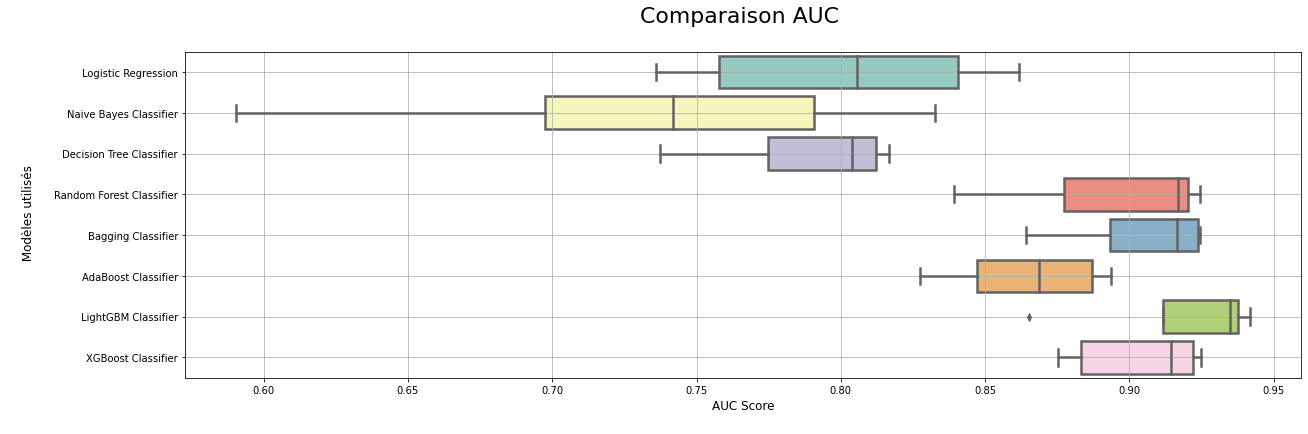

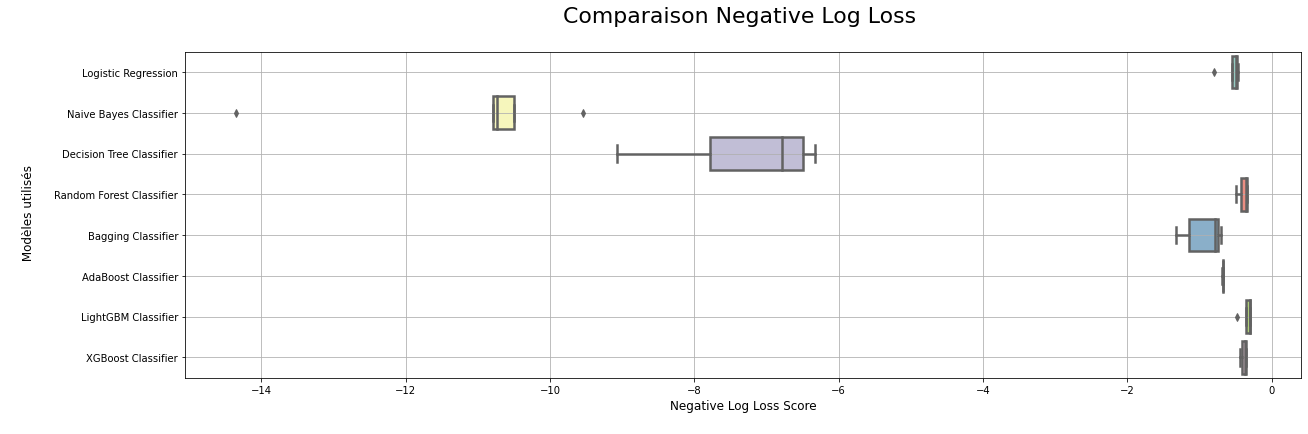

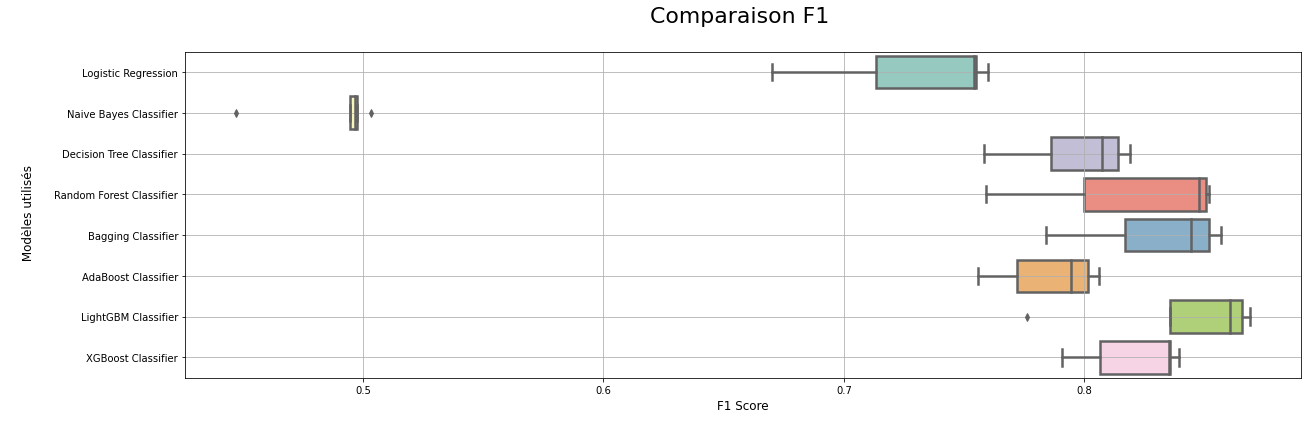

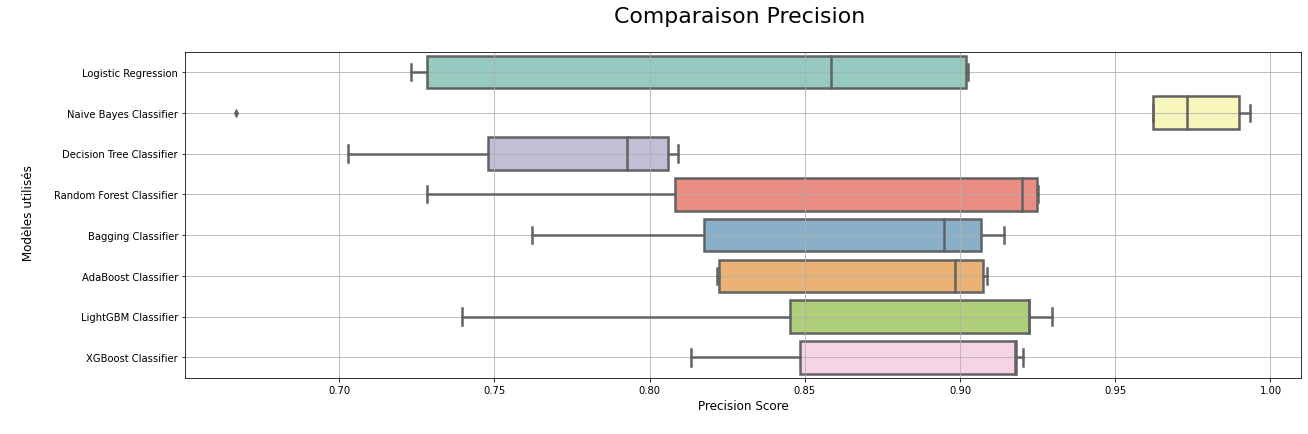

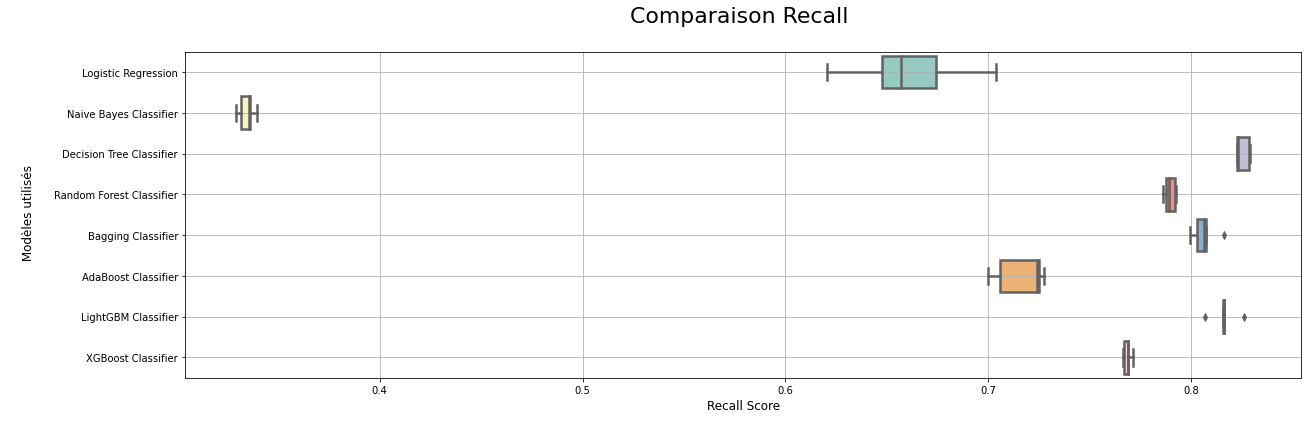

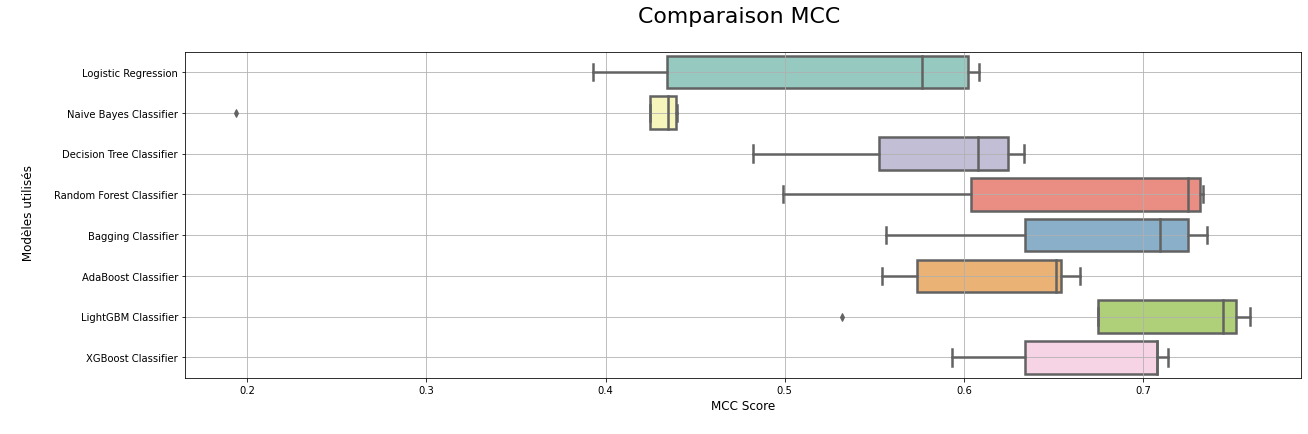

In [ ]:
# Comparaison des métriques avec la cross-validation:
compare_model(auc_results_NM3, 'AUC', names)
compare_model(loss_results_NM3, 'Negative Log Loss', names)
compare_model(f1_results_NM3, 'F1', names)
compare_model(precision_results_NM3, 'Precision', names)
compare_model(recall_results_NM3, 'Recall', names)
compare_model(MCC_results_NM3, 'MCC', names)

In [ ]:
# Bilan de performance:
summary_NM3 = model_results_NM3.drop(['ROC AUC STD', 'Log loss STD', 'F1 STD', 'Precision STD', 'Recall STD', 'MCC STD'],1)
summary_NM3.columns = ['Model', 'Roc_AUC', 'Log_loss', 'F1', 'Precision', 'Recall', 'MCC']
summary_NM3 = summary_NM3.sort_values(by = ['Log_loss','Roc_AUC','MCC'], ascending = [True, False, False])
summary_NM3

,Model,Roc_AUC,Log_loss,F1,Precision,Recall,MCC
6,LightGBM Classifier,91.82,0.35,84.14,87.17,81.61,69.26
7,XGBoost Classifier,90.39,0.38,82.15,88.36,76.86,67.15
3,Random Forest Classifier,89.55,0.39,82.18,86.12,78.94,65.85
0,Logistic Regression,80.04,0.56,73.05,82.28,66.05,52.29
5,AdaBoost Classifier,86.48,0.68,78.60,87.17,71.64,61.97
4,Bagging Classifier,90.44,0.94,83.08,85.91,80.64,67.21
2,Decision Tree Classifier,78.89,7.29,79.69,77.17,82.51,58.01
1,Naive Bayes Classifier,73.05,11.19,48.77,91.71,33.43,38.65


In [ ]:
# Enregistrement des résultats:
model_results_NM3.to_csv('/content/gdrive/My Drive/microsoft_ia/Analyses Projet CO/Resultats/model_results_NM3.csv', index = False)

In [ ]:
%%time


models = []
models.append([LogisticRegression(), 'Logistic Regression_NM3'])
models.append([GaussianNB(), 'Naive Bayes Classifier_NM3'])
models.append([DecisionTreeClassifier(), 'Decision Tree Classifier_NM3'])
models.append([RandomForestClassifier(), 'Random Forest Classifier_NM3'])
models.append([BaggingClassifier(), 'Bagging Classifier_NM3'])
models.append([AdaBoostClassifier(), 'AdaBoost Classifier_NM3']) 
models.append([LGBMClassifier(metrics = 'binary_logloss', objective='binary'), 'LightGBM Classifier_NM3'])
models.append([XGBClassifier(eval_metric = 'logloss', objective = 'binary:logistic', tree_method='hist'), 'XGBoost Classifier_NM3'])

# Création d'un tableau reportant les performances de chaque modèle
evaluation = ['Model', 'Roc_AUC', 'Log_loss', 'F1', 'Precision', 'Recall', 'MCC']
model_validation_NM3 = pd.DataFrame(columns=evaluation)

i = 0

# Evaluation des modèles utilisant le k-fold cross-validation:
for model, name in models:
    print(f'Entrainement en cours sur : {name}')
    
    # Entrainement et Evaluation:
    
    model = model.fit(X_NM3, y_NM3)
    y_pred = model.predict(X_valid)
    probability = model.predict_proba(X_valid)
    probability = probability[:,1]

    auc = metrics.roc_auc_score(y_valid, probability)
    logloss = metrics.log_loss(y_valid, probability)
    f1 = metrics.f1_score(y_valid, y_pred)
    precision = metrics.precision_score(y_valid, y_pred)
    recall = metrics.recall_score(y_valid, y_pred)
    MCC = metrics.matthews_corrcoef(y_valid, y_pred)

    model_validation_NM3.loc[i] = [name, auc, logloss, f1, precision, recall, MCC]
    i += 1

Entrainement en cours sur : Logistic Regression_NM3
Entrainement en cours sur : Naive Bayes Classifier_NM3
Entrainement en cours sur : Decision Tree Classifier_NM3
Entrainement en cours sur : Random Forest Classifier_NM3
Entrainement en cours sur : Bagging Classifier_NM3
Entrainement en cours sur : AdaBoost Classifier_NM3
Entrainement en cours sur : LightGBM Classifier_NM3
Entrainement en cours sur : XGBoost Classifier_NM3
CPU times: user 1min 25s, sys: 2.14 s, total: 1min 27s
Wall time: 1min 25s


In [ ]:
valid_summary_NM3 = model_validation_NM3.sort_values(by = ['Log_loss','Roc_AUC','MCC'], ascending = [True, False, False])
valid_summary_NM3

,Model,Roc_AUC,Log_loss,F1,Precision,Recall,MCC
6,LightGBM Classifier_NM3,0.954258,0.224014,0.635363,0.518261,0.820831,0.623238
7,XGBoost Classifier_NM3,0.915892,0.322836,0.552961,0.429526,0.775950,0.539847
3,Random Forest Classifier_NM3,0.908615,0.379720,0.429682,0.293635,0.800626,0.431170
0,Logistic Regression_NM3,0.781566,0.520175,0.227528,0.137243,0.664998,0.200212
4,Bagging Classifier_NM3,0.950723,0.592924,0.629031,0.513399,0.811891,0.616041
5,AdaBoost Classifier_NM3,0.863206,0.682769,0.497540,0.381694,0.714350,0.478659
1,Naive Bayes Classifier_NM3,0.718916,1.406930,0.497135,0.943972,0.337416,0.550072
2,Decision Tree Classifier_NM3,0.858497,4.044247,0.476701,0.334293,0.830487,0.480000


In [ ]:
valid_summary_NM3.to_csv('/content/gdrive/My Drive/microsoft_ia/Analyses Projet CO/Resultats/valid_summary_NM3.csv', index = False)

## Stratégie de Sur-Echantillonnnage
Pour lutter contre le déséquilibre de classe, plusieurs méthodes de sur-échantillonnage de la classe minoritaire sont envisageables. La première est de tout simplement décupler les données pour atteindre un ratio équilibré. Une autre option est de créer des données de la classe minoritaire par des algorithmes tels que SMOTE (et ses alternatifs) ou encore ADASYN.

https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

In [ ]:
# Transformation:
Smote_sample = SMOTE()
X_smote, y_smote = Smote_sample.fit_resample(X_train, y_train)

Taille du Dataset Train = 950766


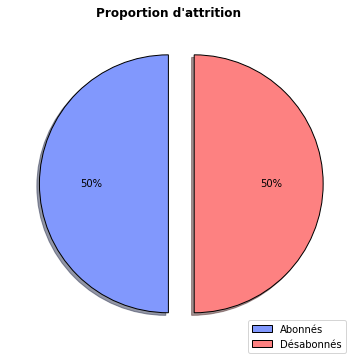

In [ ]:
print(f'Taille du Dataset Train = {y_smote.shape[0]}')
proportion_churn(y_smote.to_frame(), 'is_churn')

In [ ]:
%%time


models = []
models.append([LogisticRegression(), 'Logistic Regression'])
models.append([GaussianNB(), 'Naive Bayes Classifier'])
models.append([DecisionTreeClassifier(), 'Decision Tree Classifier'])
models.append([RandomForestClassifier(), 'Random Forest Classifier'])
models.append([BaggingClassifier(), 'Bagging Classifier'])
models.append([AdaBoostClassifier(), 'AdaBoost Classifier'])
models.append([LGBMClassifier(metrics = 'binary_logloss', objective='binary'), 'LightGBM Classifier'])
models.append([XGBClassifier(eval_metric = 'logloss', objective = 'binary:logistic', tree_method='hist'), 'XGBoost Classifier'])

# Evaluation des modèles:
names = []
auc_results_smote = []
loss_results_smote = []
f1_results_smote = []
precision_results_smote = []
recall_results_smote = []
MCC_results_smote = []

# Création d'un tableau reportant les performances de chaque modèle:
col = ['Model', 'ROC AUC Mean', 'ROC AUC STD', 'Log loss Mean', 'Log loss STD', 
       'F1 Mean', 'F1 STD', 'Precision Mean', 'Precision STD', 'Recall Mean', 
       'Recall STD', 'MCC Mean', 'MCC STD']

model_results_smote = pd.DataFrame(columns=col)

# Metrics :
scoring = {"AUC": "roc_auc", 
           "Loss": 'neg_log_loss',
           "F1" : 'f1',
           "Precision":'precision',
           "Recall":'recall',
           "MCC": metrics.make_scorer(matthews_corrcoef)}
i = 0

# Evaluation des modèles utilisant le k-fold cross-validation:
for model, name in models:
    print(f'Entrainement en cours sur : {name}')
    
    # Score:
    
    cv_results = model_selection.cross_validate(model, X_smote, y_smote, cv = StratifiedKFold(5), scoring = scoring)
    
    auc_results_smote.append(cv_results['test_AUC'])
    loss_results_smote.append(cv_results['test_Loss'])
    f1_results_smote.append(cv_results['test_F1'])
    precision_results_smote.append(cv_results['test_Precision'])
    recall_results_smote.append(cv_results['test_Recall'])
    MCC_results_smote.append(cv_results['test_MCC'])
    
    names.append(name)
    model_results_smote.loc[i] = [name,
                            round(cv_results['test_AUC'].mean()*100, 2),
                            round(cv_results['test_AUC'].std()*100, 2),
                            round(cv_results['test_Loss'].mean()*-1, 2),
                            round(cv_results['test_Loss'].std(), 2),
                            round(cv_results['test_F1'].mean()*100, 2),
                            round(cv_results['test_F1'].std()*100, 2),
                            round(cv_results['test_Precision'].mean()*100, 2),
                            round(cv_results['test_Precision'].std()*100, 2),
                            round(cv_results['test_Recall'].mean()*100, 2),
                            round(cv_results['test_Recall'].std()*100, 2),
                            round(cv_results['test_MCC'].mean()*100, 2),
                            round(cv_results['test_MCC'].std()*100, 2)]
    i += 1

Entrainement en cours sur : Logistic Regression
Entrainement en cours sur : Naive Bayes Classifier
Entrainement en cours sur : Decision Tree Classifier
Entrainement en cours sur : Random Forest Classifier
Entrainement en cours sur : Bagging Classifier
Entrainement en cours sur : AdaBoost Classifier
Entrainement en cours sur : LightGBM Classifier
Entrainement en cours sur : XGBoost Classifier
CPU times: user 1h 36min 17s, sys: 1min 4s, total: 1h 37min 22s
Wall time: 1h 35min 5s


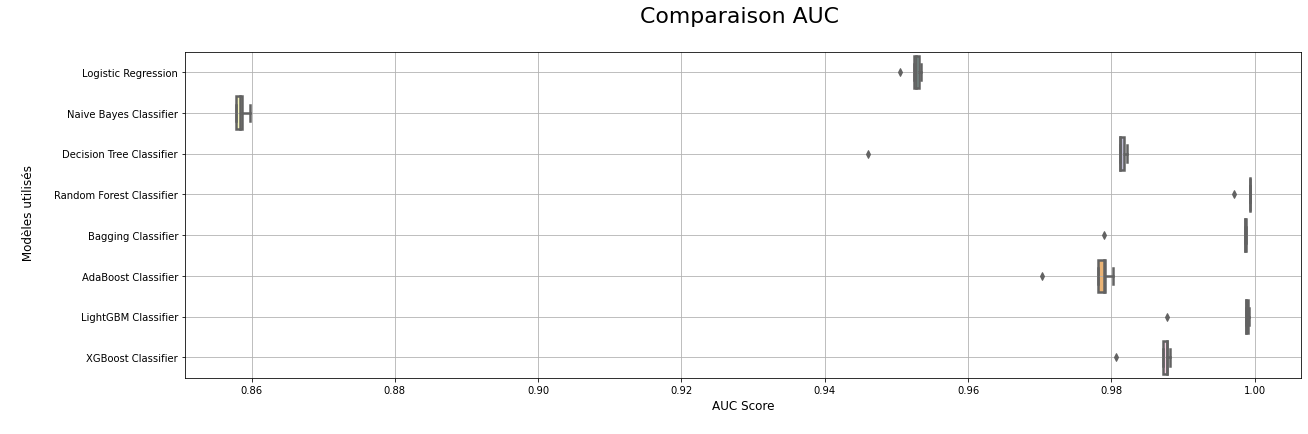

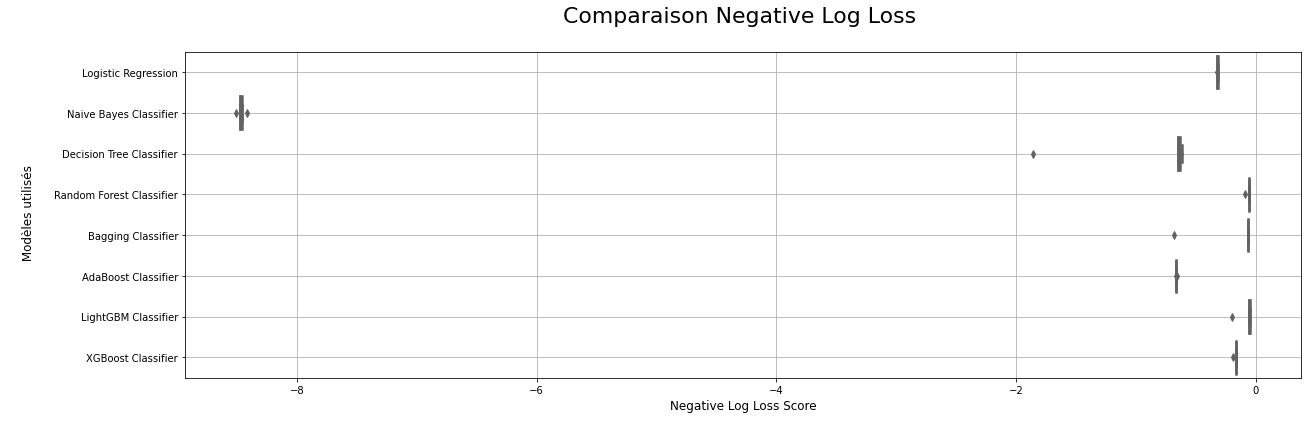

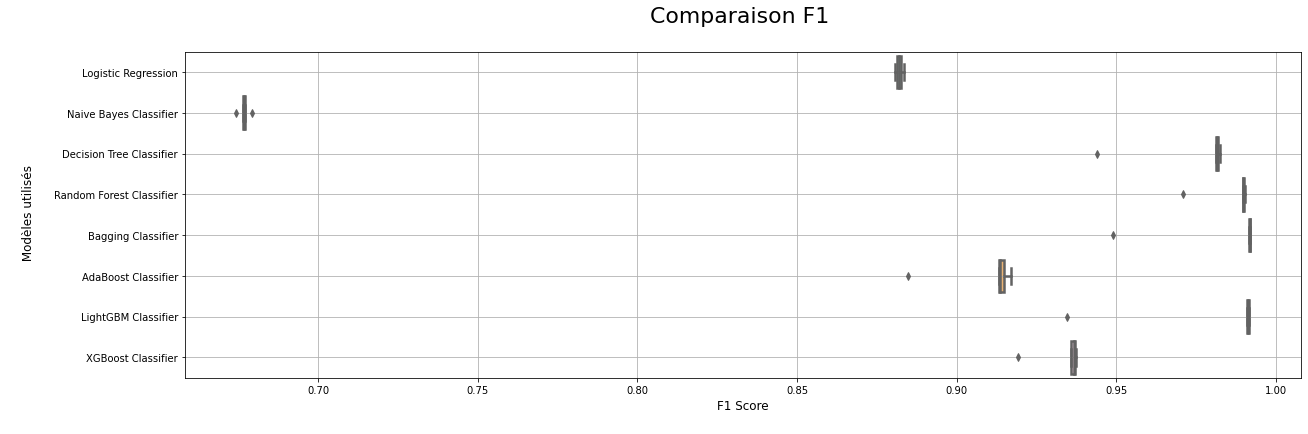

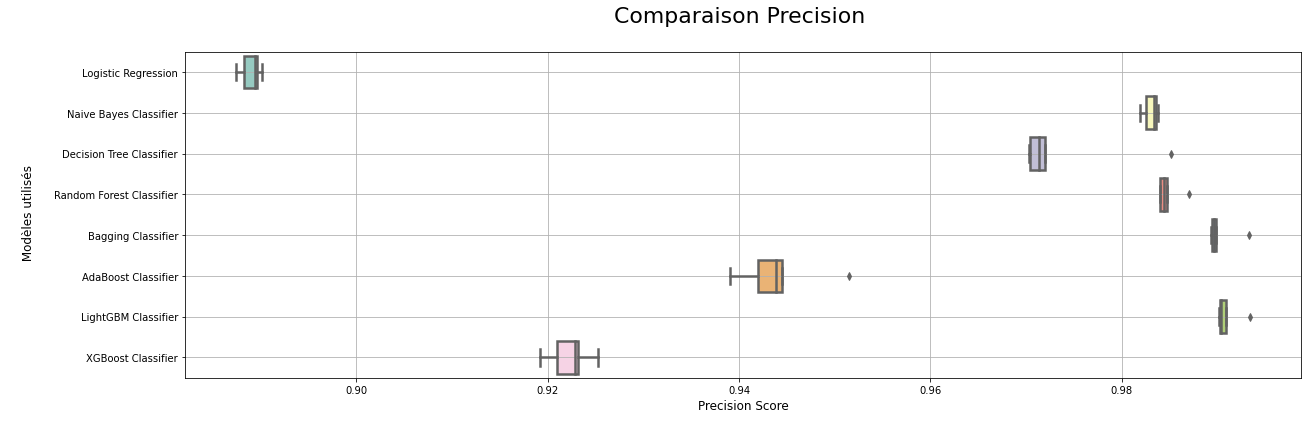

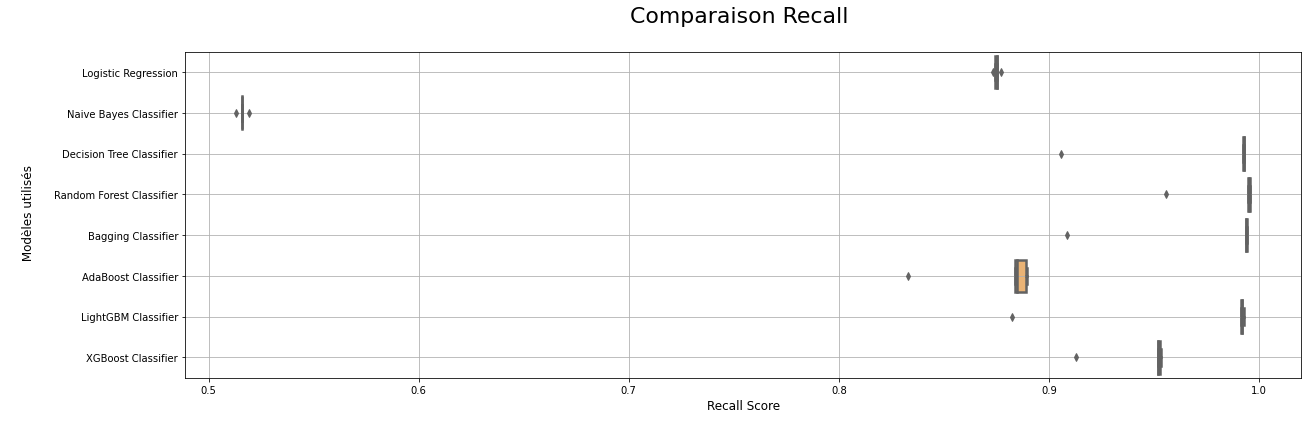

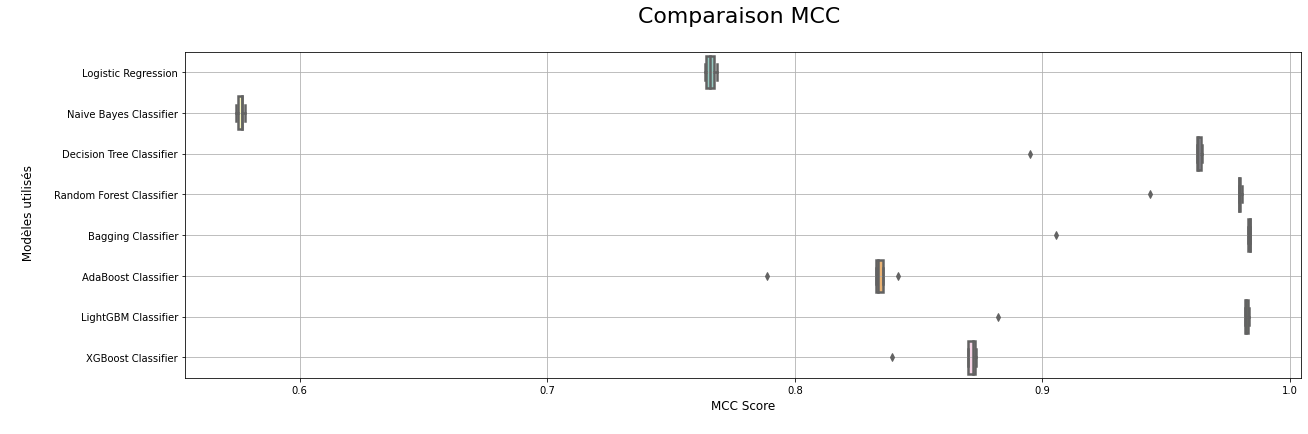

In [ ]:
# Comparaison des métriques avec la cross-validation:
compare_model(auc_results_smote, 'AUC', names)
compare_model(loss_results_smote, 'Negative Log Loss', names)
compare_model(f1_results_smote, 'F1', names)
compare_model(precision_results_smote, 'Precision', names)
compare_model(recall_results_smote, 'Recall', names)
compare_model(MCC_results_smote, 'MCC', names)

In [ ]:
# Bilan de performance:
summary_smote = model_results_smote.drop(['ROC AUC STD', 'Log loss STD', 'F1 STD', 'Precision STD', 'Recall STD', 'MCC STD'],1)
summary_smote.columns = ['Model', 'Roc_AUC', 'Log_loss', 'F1', 'Precision', 'Recall', 'MCC']
summary_smote = summary_smote.sort_values(by = ['Log_loss','Roc_AUC','MCC'], ascending = [True, False, False])
summary_smote

,Model,Roc_AUC,Log_loss,F1,Precision,Recall,MCC
3,Random Forest Classifier,99.89,0.07,98.61,98.48,98.76,97.25
6,LightGBM Classifier,99.67,0.08,98.00,99.10,97.02,96.25
7,XGBoost Classifier,98.63,0.17,93.32,92.23,94.46,86.53
4,Bagging Classifier,99.48,0.19,98.33,99.03,97.70,96.80
0,Logistic Regression,95.24,0.32,88.20,88.90,87.51,76.59
5,AdaBoost Classifier,97.74,0.66,90.87,94.42,87.60,82.65
2,Decision Tree Classifier,97.45,0.88,97.42,97.39,97.54,94.97
1,Naive Bayes Classifier,85.85,8.47,67.67,98.31,51.59,57.62


In [ ]:
model_results_smote.to_csv('/content/gdrive/My Drive/microsoft_ia/Analyses Projet CO/Resultats/model_results_smote.csv', index = False)

In [ ]:
models = []
models.append([LogisticRegression(), 'Logistic Regression_smote'])
models.append([GaussianNB(), 'Naive Bayes Classifier_smote'])
models.append([DecisionTreeClassifier(), 'Decision Tree Classifier_smote'])
models.append([RandomForestClassifier(), 'Random Forest Classifier_smote'])
models.append([BaggingClassifier(), 'Bagging Classifier_smote'])
models.append([AdaBoostClassifier(), 'AdaBoost Classifier_smote']) 
models.append([LGBMClassifier(metrics = 'binary_logloss', objective='binary'), 'LightGBM Classifier_smote'])
models.append([XGBClassifier(eval_metric = 'logloss', objective = 'binary:logistic', tree_method='hist'), 'XGBoost Classifier_smote'])

# Création d'un tableau reportant les performances de chaque modèle
evaluation = ['Model', 'Roc_AUC', 'Log_loss', 'F1', 'Precision', 'Recall', 'MCC']
model_validation_smote = pd.DataFrame(columns=evaluation)

i = 0

# Evaluation des modèles utilisant le k-fold cross-validation:
for model, name in models:
    print(f'Entrainement en cours sur : {name}')
    
    # Entrainement et Evaluation:
    
    model = model.fit(X_smote, y_smote)
    y_pred = model.predict(X_valid)
    probability = model.predict_proba(X_valid)
    probability = probability[:,1]

    auc = metrics.roc_auc_score(y_valid, probability)
    logloss = metrics.log_loss(y_valid, probability)
    f1 = metrics.f1_score(y_valid, y_pred)
    precision = metrics.precision_score(y_valid, y_pred)
    recall = metrics.recall_score(y_valid, y_pred)
    MCC = metrics.matthews_corrcoef(y_valid, y_pred)

    model_validation_smote.loc[i] = [name, auc, logloss, f1, precision, recall, MCC]
    i += 1

Entrainement en cours sur : Logistic Regression_smote
Entrainement en cours sur : Naive Bayes Classifier_smote
Entrainement en cours sur : Decision Tree Classifier_smote
Entrainement en cours sur : Random Forest Classifier_smote
Entrainement en cours sur : Bagging Classifier_smote
Entrainement en cours sur : AdaBoost Classifier_smote
Entrainement en cours sur : LightGBM Classifier_smote
Entrainement en cours sur : XGBoost Classifier_smote


In [ ]:
valid_summary_smote = model_validation_smote.sort_values(by = ['Log_loss','Roc_AUC','MCC'], ascending = [True, False, False])
valid_summary_smote

,Model,Roc_AUC,Log_loss,F1,Precision,Recall,MCC
6,LightGBM Classifier_smote,0.974135,0.088697,0.789580,0.853757,0.734376,0.778785
3,Random Forest Classifier_smote,0.973334,0.100887,0.768132,0.797957,0.740456,0.753452
7,XGBoost Classifier_smote,0.966501,0.174655,0.570266,0.426958,0.858382,0.569736
4,Bagging Classifier_smote,0.944158,0.281024,0.792797,0.851092,0.741976,0.781691
0,Logistic Regression_smote,0.945568,0.336311,0.502520,0.352720,0.873491,0.511784
5,AdaBoost Classifier_smote,0.950848,0.666607,0.586158,0.473739,0.768529,0.569691
1,Naive Bayes Classifier_smote,0.859118,1.326218,0.633862,0.799292,0.525168,0.629363
2,Decision Tree Classifier_smote,0.859064,1.386147,0.704064,0.668677,0.743406,0.683705


In [ ]:
valid_summary_smote.to_csv('/content/gdrive/My Drive/microsoft_ia/Analyses Projet CO/Resultats/valid_summary_smote.csv', index = False)

## Stratégie Combinée Undersampling et Oversampling

Quelques exemples d'échantillonnages avec des ratios différents en utilisant un modèle unique. Le mieux serait d'effectuer cette stratégie pour tous les modèles utilisés (Réseau de neurones, Modèles Stacking, d'ensembles etc...). Cependant la tâche reste fastidieuse et longue.

https://towardsdatascience.com/how-to-deal-with-imbalanced-data-in-python-f9b71aba53eb

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Evaluation des modèles:
ratio = []
auc_results = []
loss_results = []
f1_results = []
precision_results = []
recall_results = []
MCC_results = []

# Metrics :
scoring = {"AUC": "roc_auc", 
           "Loss": 'neg_log_loss',
           "F1" : 'f1',
           "Precision":'precision',
           "Recall":'recall',
           "MCC": metrics.make_scorer(matthews_corrcoef)}

# Création d'un tableau reportant les performances de chaque modèle:
col = ['Model', 'ROC AUC Mean', 'ROC AUC STD', 'Log loss Mean', 'Log loss STD', 
       'F1 Mean', 'F1 STD', 'Precision Mean', 'Precision STD', 'Recall Mean', 
       'Recall STD', 'MCC Mean', 'MCC STD']

model_ratio_strategy = pd.DataFrame(columns=col)

OverStrategy =  [0.3,0.4,0.5]
UnderStrategy = [0.7,0.6,0.5]

i = 0

for o in OverStrategy:
    for u in UnderStrategy:
  
        model = LGBMClassifier(metrics = 'binary_logloss', objective='binary')
        over = SMOTE(sampling_strategy = o)
        under = RandomUnderSampler(sampling_strategy = u)
        steps = [('over', over), ('under', under), ('model', model)]
        pipeline = Pipeline(steps=steps)

        cv_results = model_selection.cross_validate(pipeline, X_train, y_train, scoring = scoring, cv = StratifiedKFold(5))

        auc_results.append(cv_results['test_AUC'])
        loss_results.append(cv_results['test_Loss'])
        f1_results.append(cv_results['test_F1'])
        precision_results.append(cv_results['test_Precision'])
        recall_results.append(cv_results['test_Recall'])
        MCC_results.append(cv_results['test_MCC'])

        ratio.append([o,u])
        model_ratio_strategy.loc[i] = [[o,u],
                                round(cv_results['test_AUC'].mean()*100, 2),
                                round(cv_results['test_AUC'].std()*100, 2),
                                round(cv_results['test_Loss'].mean()*-1, 2),
                                round(cv_results['test_Loss'].std(), 2),
                                round(cv_results['test_F1'].mean()*100, 2),
                                round(cv_results['test_F1'].std()*100, 2),
                                round(cv_results['test_Precision'].mean()*100, 2),
                                round(cv_results['test_Precision'].std()*100, 2),
                                round(cv_results['test_Recall'].mean()*100, 2),
                                round(cv_results['test_Recall'].std()*100, 2),
                                round(cv_results['test_MCC'].mean()*100, 2),
                                round(cv_results['test_MCC'].std()*100, 2)]

        print(f"Over : {o} Under : {u}\t MCC : {cv_results['test_MCC'].mean()}\t Loss : {cv_results['test_Loss'].mean()*-1}")
        i += 1

Over : 0.3 Under : 0.7	 MCC : 0.7716135130972492	 Loss : 0.09144136417549933
Over : 0.3 Under : 0.6	 MCC : 0.7811282747366386	 Loss : 0.0859181253826907
Over : 0.3 Under : 0.5	 MCC : 0.7866776923072185	 Loss : 0.0812373946585295
Over : 0.4 Under : 0.7	 MCC : 0.7786272769005165	 Loss : 0.08551436855990276
Over : 0.4 Under : 0.6	 MCC : 0.7843008510489557	 Loss : 0.08133373715173944
Over : 0.4 Under : 0.5	 MCC : 0.7867265979041622	 Loss : 0.07787631981379999
Over : 0.5 Under : 0.7	 MCC : 0.780489971984893	 Loss : 0.08213662360743794
Over : 0.5 Under : 0.6	 MCC : 0.7842613705101497	 Loss : 0.07888295907839417
Over : 0.5 Under : 0.5	 MCC : 0.784216908028309	 Loss : 0.07669685063480552



LogLoss : 0.07591241612499873	 AUC : 0.9779411815042502	 F1 : 0.7985420155649691
Recall : 0.7247206079570854	 Precision : 0.889108259295821	 MCC : 0.7908454921640232



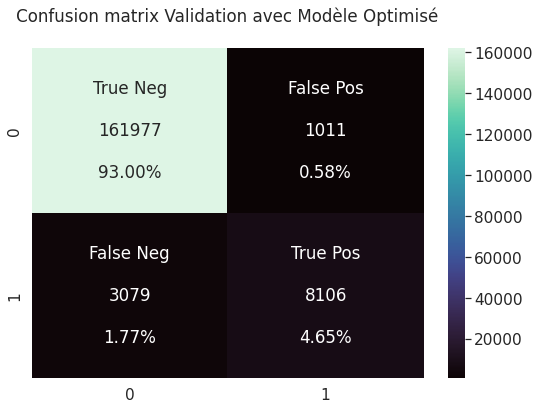

In [ ]:
model = LGBMClassifier(metrics = 'binary_logloss', objective='binary')

over = SMOTE(sampling_strategy = 0.5)
X_over, y_over = over.fit_resample(X_train, y_train)
under = RandomUnderSampler(sampling_strategy = 0.5)
X_combined, y_combined = under.fit_resample(X_over, y_over)

model = model.fit(X_combined, y_combined)
y_pred = model.predict(X_valid)
probability = model.predict_proba(X_valid)
probability = probability[:,1]

auc = metrics.roc_auc_score(y_valid, probability)
logloss = metrics.log_loss(y_valid, probability)
f1 = metrics.f1_score(y_valid, y_pred)
precision = metrics.precision_score(y_valid, y_pred)
recall = metrics.recall_score(y_valid, y_pred)
MCC = metrics.matthews_corrcoef(y_valid, y_pred)
print(f'\nLogLoss : {logloss}\t AUC : {auc}\t F1 : {f1}\nRecall : {recall}\t Precision : {precision}\t MCC : {MCC}\n')

plt.figure(figsize=(8,6))
df_cm = confusion_matrix(y_valid, y_pred) 
group_names = ["True Neg\n", "False Pos\n", "False Neg\n", "True Pos\n"]
group_counts = ["{0:0.0f}\n".format(value) for value in df_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in df_cm.flatten()/np.sum(df_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=labels, fmt="", cmap='mako').set_title('Confusion matrix Validation avec Modèle Optimisé\n')
class_names=[0,1]
tick_marks = np.arange(len(class_names))

plt.tight_layout()
plt.show()

## Utilisation de modèles Ensemble de samplers
*Imblearn* propose divers modèles spécialisés contrant ces phénomènes de déséquilibre de classes. Deux modèles avec des paramétrages à défaut (Ensemble et Boosting) sont proposés :

https://imbalanced-learn.org/stable/ensemble.html

BalancedRandomForestClassifier:
LogLoss : 0.2185141678965018	 AUC : 0.9739457020890347	 F1 : 0.541600644206042
Recall : 0.9320518551631649	 Precision : 0.38170035149384884	 MCC : 0.558506780601123

RUSBoostClassifier:
LogLoss : 0.687030437135581	 AUC : 0.9600577885349172	 F1 : 0.5402854446128765
Recall : 0.8444345105051408	 Precision : 0.39721591386996385	 MCC : 0.5401293913905348



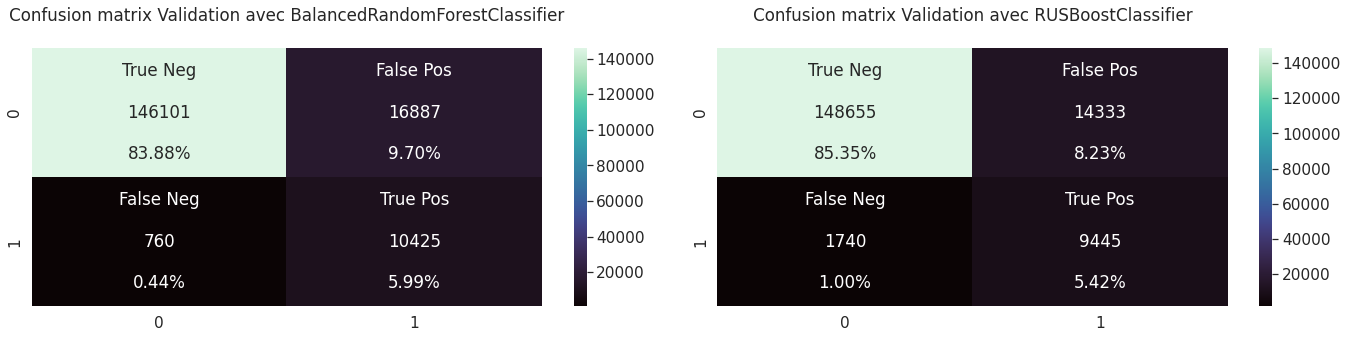

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier

BRFC = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
BRFC.fit(X_train, y_train)

y_pred1 = BRFC.predict(X_valid)
probability1 = BRFC.predict_proba(X_valid)
probability1 = probability1[:,1]

auc = metrics.roc_auc_score(y_valid, probability1)
logloss = metrics.log_loss(y_valid, probability1)
f1 = metrics.f1_score(y_valid, y_pred1)
precision = metrics.precision_score(y_valid, y_pred1)
recall = metrics.recall_score(y_valid, y_pred1)
MCC = metrics.matthews_corrcoef(y_valid, y_pred1)
print(f'BalancedRandomForestClassifier:\nLogLoss : {logloss}\t AUC : {auc}\t F1 : {f1}\nRecall : {recall}\t Precision : {precision}\t MCC : {MCC}\n')

RUSBC = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R', random_state=0)
RUSBC.fit(X_train, y_train)

y_pred2 = RUSBC.predict(X_valid)
probability2 = RUSBC.predict_proba(X_valid)
probability2 = probability2[:,1]

auc = metrics.roc_auc_score(y_valid, probability2)
logloss = metrics.log_loss(y_valid, probability2)
f1 = metrics.f1_score(y_valid, y_pred2)
precision = metrics.precision_score(y_valid, y_pred2)
recall = metrics.recall_score(y_valid, y_pred2)
MCC = metrics.matthews_corrcoef(y_valid, y_pred2)
print(f'RUSBoostClassifier:\nLogLoss : {logloss}\t AUC : {auc}\t F1 : {f1}\nRecall : {recall}\t Precision : {precision}\t MCC : {MCC}\n')

fig, ax = plt.subplots(1, 2, figsize = (20, 5))
df_cm = confusion_matrix(y_valid, y_pred1) 
group_names = ["True Neg\n", "False Pos\n", "False Neg\n", "True Pos\n"]
group_counts = ["{0:0.0f}\n".format(value) for value in df_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in df_cm.flatten()/np.sum(df_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.set(font_scale=1.4)
sn.heatmap(df_cm,  ax = ax[0], annot=labels, fmt="", cmap='mako').set_title('Confusion matrix Validation avec BalancedRandomForestClassifier\n')
class_names=[0,1]
tick_marks = np.arange(len(class_names))

df_cm = confusion_matrix(y_valid, y_pred2) 
group_names = ["True Neg\n", "False Pos\n", "False Neg\n", "True Pos\n"]
group_counts = ["{0:0.0f}\n".format(value) for value in df_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in df_cm.flatten()/np.sum(df_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.set(font_scale=1.4)
sn.heatmap(df_cm, ax = ax[1], annot=labels, fmt="", cmap='mako').set_title('Confusion matrix Validation avec RUSBoostClassifier\n')
class_names=[0,1]
tick_marks = np.arange(len(class_names))

plt.tight_layout()
plt.show()

## Hyperparamétrages de XGBoost sur le déséquilibre de classe
Dans cette dernière section, une calibration du paramètre *Scale_pos_weight* de XGBoost peut être utilisé par exemple afin d'ajouter, comme son nom l'indique, plus de poids sur les données de la classe minoritaire. Ce paramètre est surtout utile si la stratégie de l'entreprise souhaitant une IA de détection de l'attrition souhaite minimiser le taux de Faux Négative. Toutefois, la métrique *Log_loss* montrera une baisse de performance de ce côté là.

In [ ]:
col = ['Scale', 'Roc_AUC', 'Log_loss', 'F1', 'Precision', 'Recall', 'MCC']
Performance_scale = pd.DataFrame(columns = col)
Weight = [1, 3, 5, 7, 9, 11, 13, 15, 17]

i = 0
for w in Weight:
  model = XGBClassifier(eval_metric = 'logloss', objective = 'binary:logistic', tree_method = 'hist', scale_pos_weight = w)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_valid)
  probability = model.predict_proba(X_valid)
  probability = probability[:,1]

  auc = metrics.roc_auc_score(y_valid, probability)
  logloss = metrics.log_loss(y_valid, probability)
  f1 = metrics.f1_score(y_valid, y_pred)
  precision = metrics.precision_score(y_valid, y_pred)
  recall = metrics.recall_score(y_valid, y_pred)
  MCC = metrics.matthews_corrcoef(y_valid, y_pred)

  Performance_scale.loc[i] = [w, auc, logloss, f1, precision, recall, MCC]

  i+=1

In [ ]:
Performance_scale

,Scale,Roc_AUC,Log_loss,F1,Precision,Recall,MCC
0,1.0,0.969104,0.084254,0.752752,0.928984,0.632722,0.754441
1,3.0,0.970510,0.101788,0.759600,0.826119,0.702995,0.747255
2,5.0,0.971713,0.124149,0.720273,0.688427,0.755208,0.700987
3,7.0,0.972703,0.145642,0.674286,0.576340,0.812338,0.659048
4,9.0,0.970360,0.171116,0.598445,0.459756,0.856951,0.594976
5,11.0,0.972713,0.186286,0.573302,0.419987,0.902906,0.580825
6,13.0,0.972485,0.203851,0.515576,0.357752,0.922575,0.533452
7,15.0,0.971418,0.224061,0.508516,0.348395,0.940992,0.531036
8,17.0,0.971723,0.238290,0.507139,0.347018,0.941618,0.529944


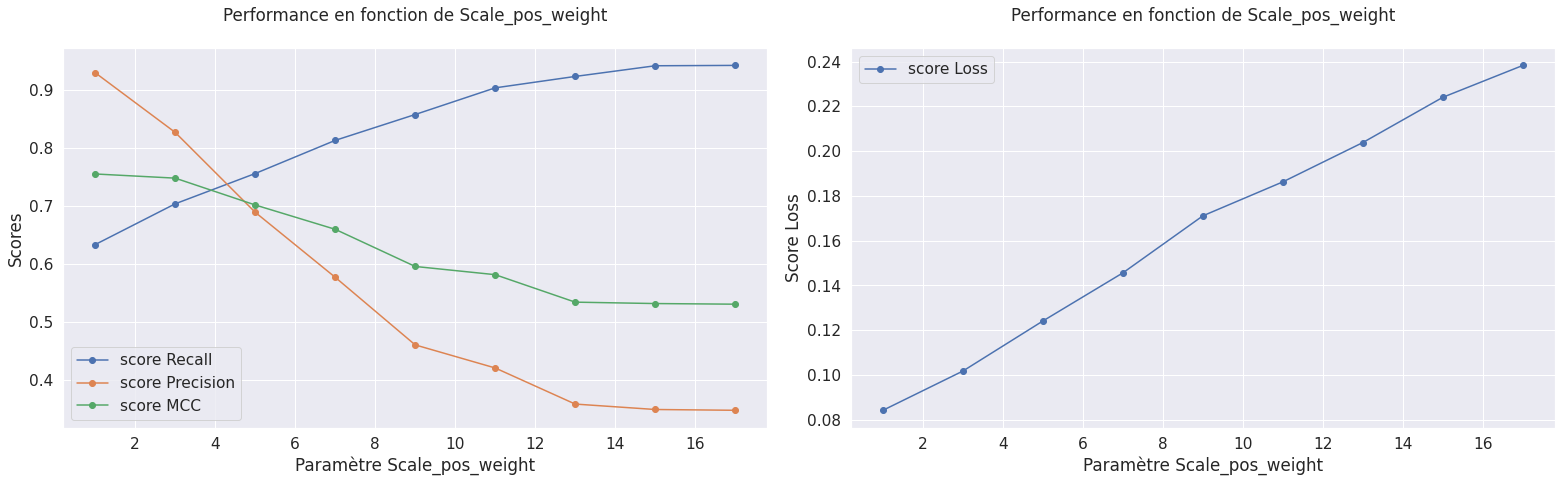

In [ ]:
W = Performance_scale['Scale']

fig, ax = plt.subplots(1,2, figsize = (22, 7))
plt.subplot(121)
plt.plot(W, Performance_scale['Recall'], '-o', label = 'score Recall')
plt.plot(W, Performance_scale['Precision'], '-o', label = 'score Precision')
plt.plot(W, Performance_scale['MCC'], '-o', label = 'score MCC')
plt.title('Performance en fonction de Scale_pos_weight\n')
plt.ylabel('Scores')
plt.xlabel('Paramètre Scale_pos_weight')
plt.legend()

plt.subplot(122)
plt.plot(W, Performance_scale['Log_loss'], '-o', label = 'score Loss')
plt.title('Performance en fonction de Scale_pos_weight\n')
plt.ylabel('Score Loss')
plt.xlabel('Paramètre Scale_pos_weight')
plt.legend()

plt.tight_layout()
plt.savefig('/content/gdrive/My Drive/microsoft_ia/Analyses Projet CO/Resultats/Score_BestFeatures_Nb.png')
plt.show()

## Définition du seuil de décision MCC-F1 Curve
Basé sur l'article *The MCC-F1 curve: a performance evaluation technique for binary classification (Cao, Chicco, & Hoffman, 2020)* https://arxiv.org/abs/2006.11278

### Fonctions
https://github.com/krishnanlab/MCC-F1-Curve-and-Metrics/blob/master/MCC-F1_code.ipynb

In [35]:
def mcc_f1(ground_truths, predicted_values):
    
    """
    The function mcc_f1 calculates MCC and F1 scores based on varying thresholds identifed by the PRC function
    based on inputs -  ground truth vaules and predicted values.
    
    Parameters
    ----------
    ground_truths, predicted_values : numpy.ndarray;
                        Input arrays; groundtruth values (True values) and predicted values.
    
    Returns
    -------
    mcc, f1, thresholds: numpy.ndarray;
                           Output arrays; Unit normalized MCC scores and F1 score values 
                           for every threshold.           
    """
    
    mcc = []   
    f1 = []
    
    # Generating thresholds with the PRC function
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(
                                    ground_truths, predicted_values)

    # For every value of the thresholds (cutoffs), calculate MCC and F1 scores :
    for T in thresholds:
        predicted_values_after_cutoff = predicted_values > T  # Positive classes are determined for every predicted value that exceeds the threshold. 
    
        mcc.append((sklearn.metrics.matthews_corrcoef(
                    ground_truths, predicted_values_after_cutoff)+1)*0.5) # get normalised MCC: change the range of MCC from [-1, 1] to [0, 1] 
        
        f1.append(sklearn.metrics.f1_score(
                    ground_truths, predicted_values_after_cutoff))
        
    mcc = np.array(mcc)
    f1 = np.array(f1)  
    
    # Resulting values are an array of MCC & F1 scores across different thresholds (cutoffs)  
    return mcc,f1, thresholds

# MCC-F1 Metric:
def MCC_F1_Metric(mcc,f1,thresholds, W_num_of_subranges = 100):
    
    """
    MCC_F1_Metric function computes the MCC-F1 metric i.e. the average distances between the predcition scores to the point of Perfect Performace (1,1) 
    and also results in the best threshold value
    
    Parameters
    ----------
    
    mcc,f1, thresholds : numpy.ndarray;
                        MCC and F1 scores across varying thresholds
    
    W_num_of_subranges : int, optional;
        Number of subranges- default = 100; 
        larger values of 𝑊 will cause the MCC-𝐹1 metric to capture the performance of a classifier more accurately.
    
    Returns
    -------
    
    MCC_F1_Met : float;
                The ratio of the average distance of the MCC-F1 score to the Point of Perfect Performace (1,1)
                A metric to compare classifier performance.
    
    Best_threshold : int;
                Index of the best prediction score threshold (𝑇), 
                Index of the point on the MCC-𝐹1 curve closest to the point of perfect performance (1,1).
    
    """
    
     
    subrange_intervals = np.linspace(np.min(mcc), np.max(mcc),W_num_of_subranges) # breaking into subranges
    
    # Computing MCC values per subrange
    
    values_per_subrange = np.zeros_like(subrange_intervals) # 'n' is the number of points per subrange
    for i in range(W_num_of_subranges-1):
        for j in mcc:
            if j >= subrange_intervals[i] and j < subrange_intervals[i+1]:
                values_per_subrange[i] = values_per_subrange[i] + 1

    # Calculating the distances between points in a subrange to the Point of perfect performance (1,1)            
    Distance_of_points_within_subrange = np.sqrt(((mcc-1)**2)+((f1-1)**2)) # calculating the Euclidean distance 𝐷𝑖            
    sum_of_distance_within_subrange = np.zeros_like(subrange_intervals)
    index = -1
    for value in mcc:
        index += 1
        for i in range(W_num_of_subranges-1):
                 if value >= subrange_intervals[i] and value < subrange_intervals[i+1]:
                        sum_of_distance_within_subrange[i] = sum_of_distance_within_subrange[i] + Distance_of_points_within_subrange[index]

    # Mean Distance across subranges
    mean_Distance_per_subrange = np.array(sum_of_distance_within_subrange/values_per_subrange)
    total_number_of_subranges = 0  
    total_sum_of_mean_distances = 0
    for i in mean_Distance_per_subrange:
        if not np.isnan(i):
            total_number_of_subranges += 1 
            total_sum_of_mean_distances += i # addition of all the means across subranges that have atleast 1 MCC value.

    grand_mean_distance = total_sum_of_mean_distances/total_number_of_subranges # P = total number of subranges that have atleast 1 MCC value
   
    """ 
    Compare the grand average distance to √2 (The distance between the point of worst performance (0,0) and 
    the point of perfect performance (1,1) is √2).That is the maximum possible distance between a point on the MCC-𝐹1 curve
    The ratio between the grand avgerage distance and √2 is taken.
    This ratio ranges between 0 and 1 (worst value = 0; best value = 1). To get the MCC-𝐹1 score, we subtract this ratio from 1
    """

    MCC_F1_Met = 1 - (grand_mean_distance /np.sqrt(2))
  
    
    # Finding the best threshold 𝑇 the point on the MCC-𝐹1 curve closest to the point of perfect performance (1,1).
   
    result = np.where(Distance_of_points_within_subrange == Distance_of_points_within_subrange.min())
    Best_threshold = result[0][0]
    print(f'T_Index = {Best_threshold}')
    print("MCC-F1 metric = {0:.2f}".format(MCC_F1_Met), "Best Threshold = {0:.2f}".format(thresholds[Best_threshold]))
    
    return MCC_F1_Met, thresholds[Best_threshold]

# Generating a plot (the overall canvas);
axis = None
def axis_plotting(total_plots): 
    global axis
    if axis == None:
        fig = plt.figure(figsize=(12,12))
        axis = []        
        for i in range(1,total_plots+1):
            ax = fig.add_subplot(total_plots, 1, i)
            axis.append(ax)
            
    
def plotting(mcc, f1, thresholds,MCC_F1_Met,Best_threshold,classifer_name = "",total_plots = 1,ax = 0):
    
        """
        Plotting function - fuction to plot the MCC and F1 scores (across varying Thresholds), and highlight the the MCC_F1 metric with the best threshold
        For multiple plots, 'total_plots' should be > 1 AND 'ax' (< total_plots) starting from  1
    
        Parameters
        ----------
        mcc,f1 : numpy.ndarray;
            MCC and F1 scores across varying thresholds
    
        MCC_F1_Met : float;
                The ratio of the average distance of the MCC-F1 score to the Point of Perfect Performace (1,1)
                A metric to compare classifier performance.
    
        Best_threshold : int;
                Index of the best prediction score threshold (𝑇), 
                Index of the point on the MCC-𝐹1 curve closest to the point of perfect performance (1,1).
                
        classifer_name : str, optional
                    default = ""
    
        total_plots: int, optional
                    Number of sub-plots to generate; default = 1
    
        ax : int, optional
            Index of subplot ([1,2,3...]); default = None
    
                            
        Returns
        -------
        
        MCC-F1 curve: 
            for multiple sublplots, adjust total_plots and ax input value.
                        
        """
        
        fig = plt.figure(figsize=(12,8))
        ax = plt.gca()
        # Labelling the plot;
        plt.plot(f1,mcc)
        plt.annotate(classifer_name + "_MCC_Met - {0:.2f}".format(
            MCC_F1_Met), 
                 (f1[Best_threshold],mcc[Best_threshold]), 
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='left') 
        
        plt.scatter(f1[Best_threshold],mcc[Best_threshold],color='red')
        ax.set(xlabel='F1 score',
               ylabel='unit−normalized MCC',title='MCC-F1 curve')
        
        # Inserting Random line
        plt.axhline(0.5,linewidth=0.7, color='green',linestyle='--')
        plt.annotate('Random line',xy =(0,0.5),xytext=(250,-15),
                    color='g', xycoords = ax.get_yaxis_transform(), 
                    textcoords="offset points", va="bottom")


        # Displaying and labelling points of performances.
        plt.scatter(1,1,color = 'black');plt.scatter(0,0,color = 'black')
        plt.annotate('Point of Perfect performance',(1,1),
                    textcoords="offset points",xytext=(-9,-2),ha='right')
        plt.annotate('Point of Worst performance',(0,0)
                    ,textcoords="offset points",xytext=(9,2),ha='left')
        
        ax.set_xticks(np.arange(0, 1.1, 0.25)); ax.set_yticks(np.arange(0, 1.1, 0.25))
        ax.set_xlim(-0.05,1.05); ax.set_ylim(-0.05,1.05)
        plt.grid(alpha = 0.3)

## Observations

In [7]:
Dataset = pd.read_csv('CSV_checkpoint/Dataset_F.csv')

# Suppression des variables temporelles:
Dataset = Dataset.drop(['transaction_date'], 1)
Dataset['membership_expire_date'] = Format_intdate(Dataset['membership_expire_date'])
Dataset['registration_init_time'] = Format_intdate(Dataset['registration_init_time'])

# Afin d'effectuer un futur encodage:
Dataset['city'] = [str(i)+'C' for i in Dataset.city]
Dataset['payment_method_id'] = [str(i)+'P' for i in Dataset.payment_method_id]
Dataset['registered_via'] = [str(i)+'R' for i in Dataset.registered_via]

# Encodage:
Dataset = pd.concat([Dataset, pd.get_dummies(Dataset.gender)],1)
Dataset = pd.concat([Dataset, pd.get_dummies(Dataset.payment_method_id)],1)
Dataset = pd.concat([Dataset, pd.get_dummies(Dataset.registered_via)],1)
Dataset = pd.concat([Dataset, pd.get_dummies(Dataset.city)],1)
Dataset = Dataset.drop(['gender', 'payment_method_id','registered_via', 'city'], 1)

# Vérification:
find_NaN(Dataset)

Dataset.head()

Aucune valeur manquante n'est détectée sur ce dataset


,msno,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,membership_expire_date,is_cancel,transaction_count,bd,registration_init_time,num_25Sum,num_50Sum,num_75Sum,num_985Sum,num_100Sum,num_unqSum,total_secsSum,num_25Mean,num_50Mean,num_75Mean,num_985Mean,num_100Mean,num_unqMean,total_secsMean,count,is_churn,price_per_day,days_fidelity,female,inconnu,male,10P,11P,12P,13P,14P,15P,16P,17P,18P,19P,20P,21P,22P,23P,26P,27P,28P,29P,30P,31P,32P,33P,34P,35P,36P,37P,38P,39P,3P,40P,41P,6P,8P,13R,3R,4R,7R,9R,10C,11C,12C,13C,14C,15C,16C,17C,18C,19C,1C,20C,21C,22C,3C,4C,5C,6C,7C,8C,9C
0,+++IubgjAxvn,30,99,99,1,20170402,0,1,-1,20160503,200.0,47.0,42.0,39.0,747.0,684.0,220954.5830,6.896552,1.620690,1.448276,1.344828,25.758621,23.586207,7619.123552,29,0,3.300000,334,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,+++KGJ1Vi2lH,30,149,149,1,20170406,0,1,27,20111001,212.0,37.0,38.0,34.0,401.0,585.0,116986.9040,7.851852,1.370370,1.407407,1.259259,14.851852,21.666667,4332.848296,27,0,4.966667,2014,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,+++MqaETxAaV,30,99,99,1,20170427,0,1,-1,20151128,41.0,9.0,3.0,9.0,624.0,509.0,140733.2220,1.708333,0.375000,0.125000,0.375000,26.000000,21.208333,5863.884250,24,0,3.300000,516,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,+++l4M/sEnP0,30,149,149,1,20170503,0,2,25,20160928,219.0,39.0,32.0,34.0,2201.0,1792.0,542811.6555,7.300000,1.300000,1.066667,1.133333,73.366667,59.733333,18093.721850,30,0,4.966667,217,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,+++r/zNZrW5d,30,149,149,1,20170402,0,1,25,20070506,192.0,41.0,25.0,27.0,862.0,765.0,231866.1780,6.400000,1.366667,0.833333,0.900000,28.733333,25.500000,7728.872600,30,0,4.966667,3619,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [8]:
# Split
r =  40
Train, REM = train_test_split(Dataset, train_size=0.7, stratify = Dataset['is_churn'], random_state = r)
Valid, Test = train_test_split(REM, test_size=0.2, stratify = REM['is_churn'], random_state = r)
print(f'Dimensions Train : {Train.shape}')
print(f'Dimensions Valid : {Valid.shape}')
print(f'Dimensions Test  : {Test.shape}\n')

# Vérification de la proportion churn:
ratio_churn(Train,'Train')
ratio_churn(Valid,'Valid')
ratio_churn(Test,'Test')

# Définition de features X et Target Y
X_train = Train.drop(['msno','is_churn'], axis = 1)
y_train = Train['is_churn'].astype(int)

X_valid = Valid.drop(['msno','is_churn'], axis = 1)
y_valid = Valid['is_churn'].astype(int)

print("\nDimension X_train dataset: ", X_train.shape)
print("Dimension y_train dataset: ",   y_train.shape)
print("Dimension X_valid dataset: ",   X_valid.shape)
print("Dimension y_valid dataset: ",   y_valid.shape)

# Standardisation des données
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2

#scaler = joblib.dump(sc_X, '/content/gdrive/My Drive/microsoft_ia/Analyses Projet CO/ScalerXGBC_BF.joblib')

X_valid2 = pd.DataFrame(sc_X.transform(X_valid))
X_valid2.columns = X_valid.columns.values
X_valid2.index = X_valid.index.values
X_valid = X_valid2

Dimensions Train : (508005, 90)
Dimensions Valid : (174173, 90)
Dimensions Test  : (43544, 90)

Proportion désabonnés sur Train :	6.42 %
Proportion désabonnés sur Valid :	6.42 %
Proportion désabonnés sur Test :	6.42 %

Dimension X_train dataset:  (508005, 88)
Dimension y_train dataset:  (508005,)
Dimension X_valid dataset:  (174173, 88)
Dimension y_valid dataset:  (174173,)


In [9]:
model = XGBClassifier(eval_metric = 'logloss', objective = 'binary:logistic', tree_method='hist', n_estimators=200, max_depth=9, learning_rate=0.05).fit(X_train, y_train)

In [42]:
X_valid = X_valid[:10000]
y_valid = y_valid[:10000]
y_pred = model.predict(X_valid)
probability = model.predict_proba(X_valid)
probability = probability[:,1]

auc = metrics.roc_auc_score(y_valid, probability)
logloss = metrics.log_loss(y_valid, probability)
f1 = metrics.f1_score(y_valid, y_pred)
precision = metrics.precision_score(y_valid, y_pred)
recall = metrics.recall_score(y_valid, y_pred)
MCC = metrics.matthews_corrcoef(y_valid, y_pred)

In [43]:
mcc,f1,thresholds = mcc_f1(y_valid,probability)
MCC_F1_Met,T_index = MCC_F1_Metric(mcc,f1,thresholds)

T_Index = 239
MCC-F1 metric = 0.63 Best Threshold = 0.34


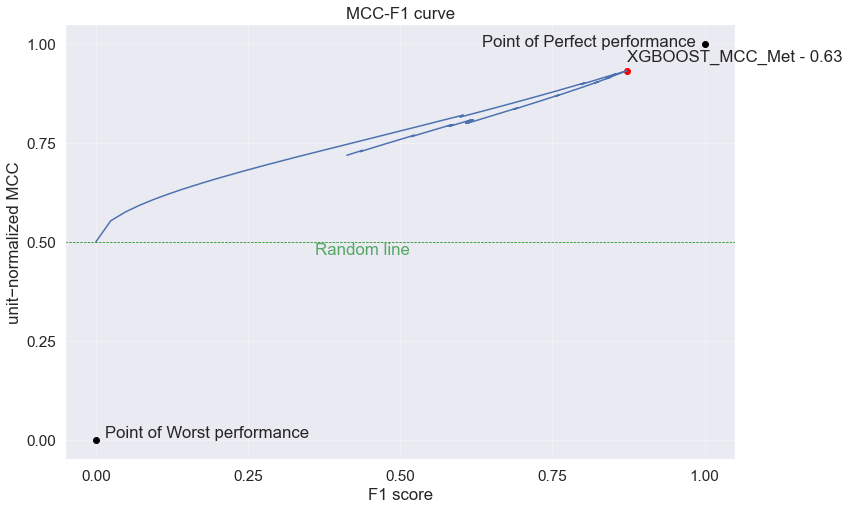

In [44]:
plotting(mcc,f1, thresholds, MCC_F1_Met, 239, total_plots = 1,ax = 1, classifer_name ='XGBOOST')

In [45]:
threshold = 0.33
new_pred = []
for i in probability:
    if i > threshold:
        new_pred.append(1)
    else:
        new_pred.append(0)

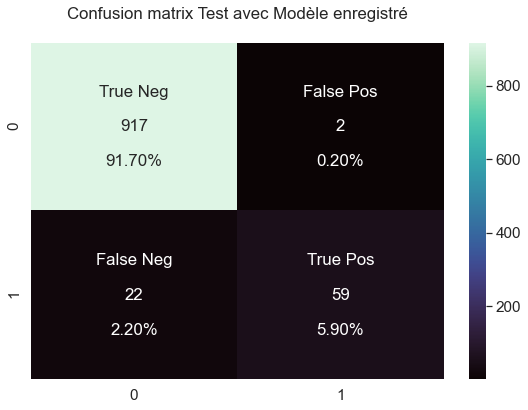

In [41]:
# Matrice de confusion avec y_pred standard:
plt.figure(figsize=(8,6))
df_cm = confusion_matrix(y_valid, y_pred) 
group_names = ["True Neg\n", "False Pos\n", "False Neg\n", "True Pos\n"]
group_counts = ["{0:0.0f}\n".format(value) for value in df_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in df_cm.flatten()/np.sum(df_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=labels, fmt="", cmap='mako').set_title('Confusion matrix Test avec Modèle enregistré\n')
class_names=[0,1]
tick_marks = np.arange(len(class_names))

plt.tight_layout()
plt.show()

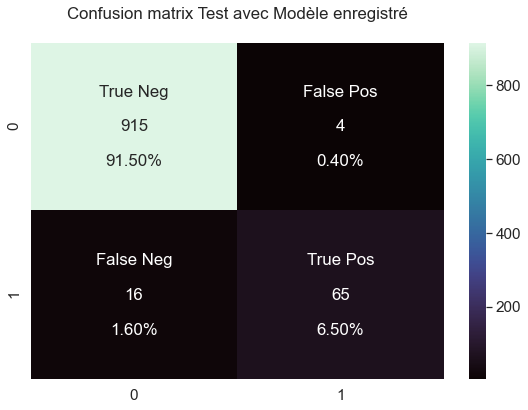

In [47]:
# Matrice de confusion avec la nouvelle prédiction seuil:
plt.figure(figsize=(8,6))
df_cm = confusion_matrix(y_valid, new_pred) 
group_names = ["True Neg\n", "False Pos\n", "False Neg\n", "True Pos\n"]
group_counts = ["{0:0.0f}\n".format(value) for value in df_cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in df_cm.flatten()/np.sum(df_cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=labels, fmt="", cmap='mako').set_title('Confusion matrix Test avec Modèle enregistré\n')
class_names=[0,1]
tick_marks = np.arange(len(class_names))

plt.tight_layout()
plt.show()

In [46]:
new_recall = metrics.recall_score(y_valid, new_pred)
classic_recall = metrics.recall_score(y_valid, y_pred)
print(f'Recall standard : {classic_recall}\nNouveau Recall : {new_recall}')

Recall standard : 0.7283950617283951
Nouveau Recall : 0.8024691358024691


In [48]:
new_MCC = metrics.matthews_corrcoef(y_valid, new_pred)
classic_MCC = metrics.matthews_corrcoef(y_valid, y_pred)
print(f'MCC standard : {classic_MCC}\nNouveau MCC : {new_MCC}')

MCC standard : 0.8278850286622041
Nouveau MCC : 0.8591464727921904


Le seuil permet d'améliorer le score *Recall* et de diminuer les Faux Négatifs. Toutefois, la part de Faux Positif augmente. Dans le cadre de ce projet, seul la probabilité de prédiction est retenue mais cette étude reste pertinente si on se focalise sur les scores *MCC/F1*.